In my last post I covered how you can fit Penalized Splines using the `glum` library in Python. Notionally `glum` was built to fit Generalized Linear Models. However it was designed to give the user the option to pass in a custom penalty matrix. We took advantage of this capability to penalize a sequence of Basis Splines and also fit Cyclic splines which allow the user to model a symmetric effect. In this post I'd like to cover how we can use this method to fit multiple spline terms. My end goal would be to develop a framework to actually incorporate into the `glum` library, but that will be in a later post. 

#### The Data

Since we will be including multiple terms it will probably be helpful to actually go over the data we are using. I am using a dataset that contains the hourly solar power generation in the state of Texas for 2022. [ERCOT](https://www.ercot.com/mp/data-products/data-product-details?id=PG7-126-M) puts a ton of data on their website so if you are ever in need of an open dataset and want to use some renewable energy data you should definitely explore their data portal. 

We will be building a simple model just to show off how we can fit multiple terms. Our model will predict the hourly solar power generation as a function of the hour of the day and the day of the year. I will also include a linear term for the total amount of solar installed that is available to help the model pick up an increase in installed solar throughout the year. 
$power \sim BS(HourOfDay) + BS(DayOfYear) + TotalSolar$
This is probably a really bad model of how solar power actually works :) but my only goal here is to build a framework for fitting multiple spline terms using `glum`, not solve the world's energy crisis. Our column of interest is the `ERCOT.PVGR.GEN` which shows the total MWs of solar generated in that hour but I'm going to make a more convenient `power_gw` field for use in this script. 


In [1]:
import numpy as np
import pandas as pd
from plotnine import *

from sklearn.preprocessing import SplineTransformer
from glum import GeneralizedLinearRegressor, GeneralizedLinearRegressorCV

## Source: https://www.ercot.com/mp/data-products/data-product-details?id=PG7-126-M
DATA_FILE = '../../data/ERCOT_2022_Hourly_Solar_Output.csv'

In [2]:
#| echo: False

retro_palette = np.array(
    ['#D73F27', '#E8713D', '#EAA86C', '#F2DDB3',
    '#81A9A0', '#2A8B99', '#1E6E8D', '#142B54']
)

def retro_palette_scaled(n = 1): 
    if n == 1:
        scaled_palette = retro_palette[0]
    if n >= 8:
        scaled_palette = retro_palette
    else:
        pos = np.round(np.linspace(0, 7, n, endpoint=True)).astype('int')
        scaled_palette = retro_palette[pos]
    
    return scaled_palette

def theme_custom(*args, **kwargs):
    custom_theme_args = dict(
        dpi = 150, 
        figure_size = (5, 3), 
        plot_background=element_rect(fill = 'lightgrey'), panel_background=element_rect(fill = 'lightgrey'))   
    
    theme_args = {**custom_theme_args, **kwargs}
    
    return theme(**theme_args)


In [3]:
#| echo: False
#| output: False
solar_df = pd.read_csv(DATA_FILE)
solar_df['time'] = pd.to_datetime(solar_df['Time (Hour-Ending)'])
solar_df['hour'] = solar_df['time'].dt.hour
solar_df['day'] = solar_df['time'].dt.dayofyear
solar_df['week'] = solar_df['time'].dt.weekofyear
solar_df['day_of_week'] = solar_df['time'].dt.day_of_week
# daily_solar_df = solar_df.groupby('day')['ERCOT.PVGR.GEN'].agg('sum').reset_index()
# daily_solar_df['power_gw'] = daily_solar_df['ERCOT.PVGR.GEN'] / 1000
# ## n_knots = 26 so there is a knot every other week :shrug:
# daily_solar_spline = SplineTransformer(n_knots = 26, include_bias = True).fit_transform(daily_solar_df[['day']])

/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [4]:
solar_df['power_gw'] = solar_df['ERCOT.PVGR.GEN'] / 1000
solar_df.head()

,Time (Hour-Ending),Date,ERCOT.LOAD,ERCOT.PVGR.GEN,"Total Solar Installed, MW","Solar Output, % of Load","Solar Output, % of Installed",Solar 1-hr MW change,Solar 1-hr % change,Daytime Hour,Ramping Daytime Hour,time,hour,day,week,day_of_week,power_gw
0,01/01/2022 01:00:00,Jan-01,38124,0,9323,0.0,0.0,NaN,NaN,False,False,2022-01-01 01:00:00,1,1,52,5,0.0
1,01/01/2022 02:00:00,Jan-01,37123,0,9323,0.0,0.0,0.0,0.0,False,False,2022-01-01 02:00:00,2,1,52,5,0.0
2,01/01/2022 03:00:00,Jan-01,35937,0,9323,0.0,0.0,0.0,0.0,False,False,2022-01-01 03:00:00,3,1,52,5,0.0
3,01/01/2022 04:00:00,Jan-01,35133,0,9323,0.0,0.0,0.0,0.0,False,False,2022-01-01 04:00:00,4,1,52,5,0.0
4,01/01/2022 05:00:00,Jan-01,34603,0,9323,0.0,0.0,0.0,0.0,False,False,2022-01-01 05:00:00,5,1,52,5,0.0


#### Building a spline 

Just like before we need to build our spline terms for each feature using the `SplineTransformer` function from the `scikit-learn.preprocessing` module. Then for each spline we need to build a 2nd order difference penalty matrix. I'm sure there is a better way to do this but I'm just going to keep track of everything in a dictionary for each term. 


In [5]:
## n_knots = 26 so there is a knot every other week :shrug:
spline_info = dict(daily = dict(), hourly = dict())
spline_info['daily'] = dict(bsplines = SplineTransformer(n_knots = 26).fit_transform(solar_df[['day']]))
spline_info['hourly'] = dict(bsplines = SplineTransformer(n_knots = 12).fit_transform(solar_df[['hour']]))
for k,v in spline_info.items():
    spline_info[k]['num_splines'] = v['bsplines'].shape[1]

for k in spline_info.keys():
    print(f'Number of Basis Splines for {k} feature: {spline_info[k]["num_splines"]}')

for k, v in spline_info.items():
    spline_info[k]['diff_matr'] = np.diff(np.eye(v['num_splines']), n = 2, axis = 0)

Number of Basis Splines for daily feature: 28
Number of Basis Splines for hourly feature: 14


Next is our combined penalty matrix. When we had one spline term we could just pass in the inner transpose product of the difference matrix (I'm not sure if that's the correct term, but the $D^TD$ matrix is what I'm referring to). Now we have two spline terms and a simple linear term. Since each spline term has its own penalty we can structure the full penalty matrix as a "sequence" of individual penalty matrices. So the difference matrices will be on the (large) diagonal and the outer triangles are filled with zeros. This way each penalty only interacts with its own corresponding spline coefficients and no other term's coefficients. 

$$\displaylines{ \mathbf{D_{hourly}} = \text{Hourly Penalty Matrix}\\
\mathbf{D_{daily}} = \text{Daily Penalty Matrix} \\
\mathbf{D_{model}} = 
\begin{bmatrix}
\mathbf{D_hourly} & \mathbf{0} \\
\mathbf{0} & \mathbf{D_{daily}}

\end{bmatrix}
}
$$

This allows us to combine any number of individual terms. More terms will obviously increase the time it takes to fit each model. I would love to test this further but my hunch is that it actually won't slow down a model fit too much. The reason is that both the model matrix containing the spline values and the penalty matrix will be "mostly sparse". What I mean by that is that they aren't completely diagonal matrices, but most sections of the matrix are only non-zero near the diagonal. The `glum` library was designed to handle sparse and nearly-sparse matrices more efficiently than other libraries. I'm hoping that these improvements will flow through to fitting GAMs, but we will have to test that on a later date. 

In thinking through how to do this in code I believe the best option is to accept a list of penalty matrices. Then iteratively fill in a matrix of zeros that is the full size of the combined penalties. This also allows us to include non-spline terms by including a 2d matrix of shape (1, 1) that will penalize the size of the linear coefficient. In my research I found that there is actually a `np.block` function, but it would force me to compute the zero matrices in the uppper and lower triangles first to then manually create the block matrix. That seems more complicated than filling in a square matrix with the penalty matrices instead. 


In [6]:
def build_multiterm_penalty(penalty_matr_list):
    ## Need to use the column shapes because the difference matrix removes rows
    num_features_list = list(map(lambda x: x.shape[1], penalty_matr_list))
    num_features = sum(num_features_list)
    ## Pre-create the matrix for efficient memory allocation
    penalty_matrix = np.zeros(shape = [num_features, num_features])
    current_row = 0
    for m in penalty_matr_list:
        size = m.shape[1]
        end_row = current_row + size
        m_square = np.dot(m.T, m)
        penalty_matrix[current_row:end_row, current_row:end_row] = m_square
        current_row = end_row

    return penalty_matrix
## simple test
build_multiterm_penalty([np.eye(2) * 2, np.eye(1) * 3])

array([[4., 0., 0.],
       [0., 4., 0.],
       [0., 0., 9.]])

So this will give us our combined penalty matrix. Now lets calculate our real one.


In [7]:
full_penalty_list = [np.eye(1), 
                     spline_info['hourly']['diff_matr'],
                     spline_info['daily']['diff_matr']]
gam_penalty = build_multiterm_penalty(full_penalty_list)
print(gam_penalty.shape)

(43, 43)


Our model matrix is a lot easier; we can simply stack the spline values we got from our transformer together. Here you can see the first feature values:


In [8]:
## build model matrix
model_matrix = np.hstack([
    solar_df[['Total Solar Installed, MW']], 
    spline_info['hourly']['bsplines'],
    spline_info['daily']['bsplines']
    ])
print(model_matrix.shape)
np.round(model_matrix[:3, :10], 2)

(8760, 43)


array([[9.323e+03, 2.000e-02, 4.900e-01, 4.700e-01, 2.000e-02, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [9.323e+03, 0.000e+00, 1.900e-01, 6.600e-01, 1.500e-01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [9.323e+03, 0.000e+00, 3.000e-02, 5.200e-01, 4.400e-01, 1.000e-02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

#### Fitting the Model

Now that we have our penalty matrix and model matrix all that we have left to do is actually fit the model. We can visualize our first day's worth of predictions to see how the model does. While this doesn't technically show only the effect of the hourly coefficients we can basically interpret it as such anyway; both the day-of-the-year spline and the linear solar capacity terms will add a fixed amount to each day. So any within-day differences are due only to the hourly smoothing spline. 


In [9]:
gam_model = GeneralizedLinearRegressor(P2 = gam_penalty, alpha = 1, fit_intercept = False).fit(X = model_matrix, y = solar_df['power_gw'])
solar_df['preds_baseline'] = gam_model.predict(model_matrix)

/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/glum/_solvers.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=1.09793e-18): result may not be accurate.


/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


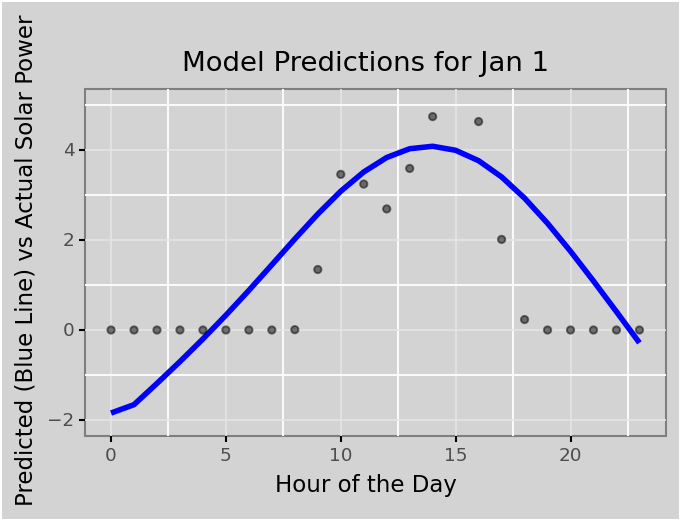

<ggplot: (-9223372036544667697)>

In [10]:
#| echo: False
(ggplot(solar_df.query('day <= 1'), aes(x = 'hour')) + 
    geom_line(aes(y = 'preds_baseline'), color = 'blue', size = 1.5) +
    geom_point(aes(y = 'power_gw'), alpha = .5) +
    xlab('Hour of the Day') + ylab('Predicted (Blue Line) vs Actual Solar Power') + ggtitle('Model Predictions for Jan 1') +
    scale_y_continuous(limits = (-2, 5)) +
    theme_bw() + theme_custom()
)

In [11]:
#| echo: False
#| eval: False
gam_model.coef_

The model certainly picks up on the general trend of solar power generation rising during the day before falling in the evening. There are *many* reasons why this does a poor job of actually modeling whats going on in the real world. One example is that the hourly term is fixed throughout the year, so the model can't pick up on the fact that summer days are longer than days in the winter. In addition the model seems to be predicting negative numbers for some hours which doesn't make any sense in the real world. All of those could be fixed with more realistic modeling choices. One thing we can fix with just our spline penalties is the fact that moving from midnight to 1am there is a discontinuity, but in actuality the predictions should basically be the same. We did this in our last post using a cyclic penalty where we penalize the difference between the first and last coefficient. We aren't going to do anything different here, but I just want to show how easy it is even with multiple spline terms. We just replace the prior difference matrix with the new cyclic difference matrix and the additional penalty will be picked up automatically when we create our `m_squared` matrix in the `build_multiterm_penalty` function. The only thing that may be different in this code is I'm going to multiply the new cyclic penalty matrix by an additional penalty term so that the model is forced to respect this new constraint.


In [12]:
def add_cyc_penalty(diff_matr):
    num_rows, num_cols = diff_matr.shape
    ## create an empty row
    cyc_row = np.zeros(num_cols)
    ## \beta @ diff_matr will penalize (\beta_{0} - \beta_{-1})
    cyc_row[0] = 1
    cyc_row[-1] = -1
    ## add the cyclic penalty row to the penalty matrix
    diff_matr_cyc = np.vstack([diff_matr, cyc_row])
    return diff_matr_cyc

cyclic_penalty = np.sqrt(3.5)
hourly_penalty_cyc = add_cyc_penalty(spline_info['hourly']['diff_matr'])
hourly_penalty_cyc = hourly_penalty_cyc * cyclic_penalty

full_penalty_list_cyc = [np.eye(1), 
                     hourly_penalty_cyc,
                     spline_info['daily']['diff_matr']]
gam_penalty_cyc = build_multiterm_penalty(full_penalty_list_cyc)

gam_model_cyc = GeneralizedLinearRegressor(P2 = gam_penalty_cyc, alpha = 1, fit_intercept = False).fit(X = model_matrix, y = solar_df['power_gw'])
solar_df['preds_cyc'] = gam_model_cyc.predict(model_matrix)

/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/glum/_solvers.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=1.58589e-18): result may not be accurate.


/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


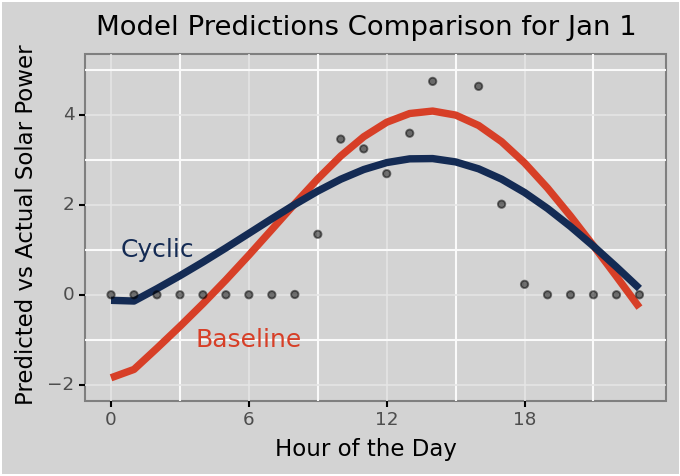

<ggplot: (-9223372036545205802)>

In [13]:
#| echo: False
model_labels = {'preds_cyc': 'Cyclic', 'preds_baseline': 'Baseline'}

plot_cyc_df = (
    solar_df.
    query('day <= 1').
    melt(id_vars = ['hour'], value_vars = ['preds_cyc', 'preds_baseline'],
         var_name = 'model', value_name = 'preds').
    assign(model_label = lambda df: [model_labels[v] for v in df['model']])
)

ggplot(plot_cyc_df, aes(x = 'hour', y = 'preds')) + \
    geom_line(aes(color = 'model_label'), size = 2) +\
    geom_point(solar_df.query('day <= 1'), aes(y = 'power_gw'), alpha = .5) +\
    scale_y_continuous(limits = (-2, 5)) +\
    scale_x_continuous(breaks = (0, 6, 12, 18)) +\
    xlab('Hour of the Day') + ylab('Predicted vs Actual Solar Power') + ggtitle('Model Predictions Comparison for Jan 1') +\
    annotate('text', label = 'Cyclic', color = retro_palette[-1], x = 2, y = 1, size = 12) +\
    annotate('text', label = 'Baseline', color = retro_palette[0], x = 6, y = -1, size = 12) +\
    guides(color = False) +\
    scale_color_manual(values = retro_palette_scaled(n = 2)) +\
    theme_bw() + theme_custom()

As you can see our hourly coefficients are more symmetric, but also much more muted than the baseline model; the baseline `gam_model` predicts a max solar output of ~4.1GW while the cyclic `gam_model_cyc` only predicts a value of ~3.2. The reason for this is that when we multiplied our cyclic penalty matrix (`hourly_penalty_cyc`) by an additional penalty value (`cyclic_penalty`) we increased the weight on the cyclic penalty but also increased the weight on the original difference penalty. This makes it harder for the model to justify consecutive spline coefficients with large differences, which makes the overall curve less, well, curvy. We can fix this by rewriting our `add_cyc_penalty` function to take the additional penalty value as an input and multiplying only the row that corresponds to the cyclic penalty (the last row) by our penalty value. 


In [14]:
def add_cyc_penalty(diff_matr, penalty = 1):
    num_rows, num_cols = diff_matr.shape
    ## create an empty row
    cyc_row = np.zeros(num_cols)
    ## \beta @ diff_matr will penalize (\beta_{0} - \beta_{-1})
    cyc_row[0] = 1
    cyc_row[-1] = -1
    ## add the cyclic penalty row to the penalty matrix
    cyc_row = cyc_row * penalty
    diff_matr_cyc = np.vstack([diff_matr, cyc_row])
    return diff_matr_cyc

cyclic_penalty = np.sqrt(10)
## Now our cyclic_penalty is an input instead of an additional step
hourly_penalty_cyc = add_cyc_penalty(spline_info['hourly']['diff_matr'], cyclic_penalty)

In [15]:
#| echo: False
full_penalty_list_cyc = [np.eye(1), 
                     hourly_penalty_cyc,
                     spline_info['daily']['diff_matr']]
gam_penalty_cyc = build_multiterm_penalty(full_penalty_list_cyc)

gam_model_cyc = GeneralizedLinearRegressor(P2 = gam_penalty_cyc, alpha = 1, fit_intercept = False).fit(X = model_matrix, y = solar_df['power_gw'])
solar_df['preds_cyc_pen'] = gam_model_cyc.predict(model_matrix)

/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/glum/_solvers.py:52: LinAlgWarning: Ill-conditioned matrix (rcond=3.25164e-19): result may not be accurate.


/Users/mm/Documents/Data Science/Blog Posts/lib/python3.7/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 1 rows containing missing values.


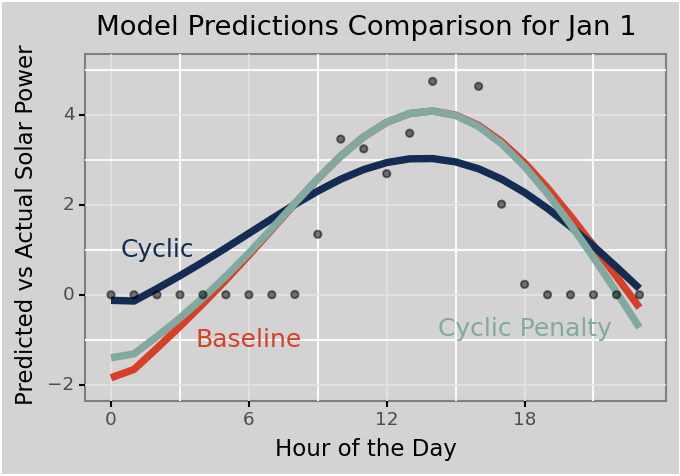

<ggplot: (-9223372036540983836)>

In [16]:
#| echo: False
model_labels['preds_cyc_pen'] = 'Cyclic Penalty'

plot_cyc_df2 = (
    solar_df.
    query('day <= 1').
    melt(id_vars = ['hour'], 
         value_vars = ['preds_cyc', 'preds_baseline', 'preds_cyc_pen'],
         var_name = 'model', value_name = 'preds').
    assign(model_label = lambda df: [model_labels[v] for v in df['model']])
)

ggplot(plot_cyc_df2, aes(x = 'hour', y = 'preds')) + \
    geom_line(aes(color = 'model_label'), size = 2) +\
    geom_point(solar_df.query('day <= 1'), aes(y = 'power_gw'), alpha = .5) +\
    scale_y_continuous(limits = (-2, 5)) +\
    scale_x_continuous(breaks = (0, 6, 12, 18)) +\
    xlab('Hour of the Day') + ylab('Predicted vs Actual Solar Power') + ggtitle('Model Predictions Comparison for Jan 1') +\
    annotate('text', label = 'Cyclic', color = retro_palette[-1], x = 2, y = 1, size = 12) +\
    annotate('text', label = 'Baseline', color = retro_palette[0], x = 6, y = -1, size = 12) +\
    annotate('text', label = 'Cyclic Penalty', color = retro_palette[4], x = 18, y = -0.75, size = 12) +\
    scale_color_manual(values = retro_palette_scaled(n = 3)[[0, 2, 1]]) +\
    guides(color = False) +\
    theme_bw() + theme_custom()

There is still some discontinuity between 11pm and midnight, but our predictions have maintained their more accurate predictions during the middle of the day while shrinking the gap. In fact, I can't seem to figure out how to close this gap. If I increase the penalty value in the updated `add_cyclic_penalty` function the coefficients really don't change. If I make it too large then `glum` will throw errors about how the `P2` matrix must be positive semi-definite. I will have to look into this but wanted to wrap this post up regardless since the core idea was just including multiple splines, which we have done. 

From here I would love to actually look at the internals in the `glum` library to see if its feasible to implement this capability directly into the library. For now hopefully this explains a little more about P-splines and fitting models with `glum`. 


In [17]:
#| echo: False
#| eval: False
def between(x, lb, ub, ge = True, le = True):
    if ge:
        lower = np.where(x >= lb, True, False)
    else:
        lower = np.where(x > lb, True, False)
    
    if le:
        upper = np.where(x <= ub, True, False)
    else:
        upper = np.where(x < ub, True, False)

    return lower & upper

days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday',
        5: 'Weekend', 6: 'Weekend'}
turkey_df = solar_df.query('(week >= 45) & (week <= 49)').assign(week = lambda df: df['week'].astype('str'))
turkey_df['Week'] = np.where(between(turkey_df['week'].astype('int'), 47, 47), 'Thanksgiving', 'Baseline')
turkey_df['weekday'] = pd.Categorical([days[i] for i in turkey_df['day_of_week']], categories = list(days.values())[:-1], ordered = True)
turkey_df_avg = turkey_df.groupby(['Week', 'hour', 'weekday'])['ERCOT.LOAD'].mean().reset_index()
turkey_df_avg['Total Load (GW)'] = turkey_df_avg['ERCOT.LOAD'] / 1000

In [18]:
#| echo: False
#| eval: False
(ggplot(turkey_df_avg, aes(x = 'hour', y = 'Total Load (GW)')) + 
    geom_line(aes(color = 'Week'), size = 2) + 
    facet_wrap('~weekday', nrow = 2) + 
    scale_x_continuous(breaks = [8, 12, 16, 20], name = 'Hour') +
    ggtitle('Thanksgiving Power Demand in Texas (2022)') +
    scale_color_manual(values = ['white', '#511f16']) + 
    labs(color = '') +
    theme(plot_background = element_rect(fill = '#B6562A'), 
          strip_background = element_rect(fill = '#9c2f2f'),
          strip_text = element_text(color = '#dbba33', face = 'bold'),
          panel_background = element_rect(fill = '#B6562A'),
          legend_background = element_rect(fill = '#B6562A'),
          legend_key = element_rect(fill = '#B6562A'),
          panel_grid_minor = element_blank(),
          panel_grid_major = element_line(color = 'grey'),
          legend_position = 'bottom', dpi = 300, figure_size=(6, 3))
)

In [19]:
#| echo: False
#| eval: False
B11, B12, B13
B21, B22, B23
B31, B32, B33

B11, B21, B31
B12, B22, B32
B13, B23, B33

# 2o1 + -o3, o2, -o1 + 2o3
# (2o1o1 + -o3o1) + (o2o2) + (-o1o3 + 2o3o3)
# 2o1^2 + o2^2 + 2o3^2 - 2o1o3
# 2o1^2 + o2^2 + 2o3^2 - 2o1(o1 + x)
# 2o1^2 + o2^2 + 2o3^2 - 2o1^2 + 2o1x
# o2^2 + 2o3^2 + 2o1x